In [1]:
# Use if u need it
# %pip install pandas numpy scikit-learn matplotlib seaborn

In [12]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import Data
data = pd.read_csv("data/online_retail_II.csv")
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [4]:
# STEP 1: Data cleaning
# Drop Duplicates
data = data.drop_duplicates()
# Trash Types to clean 
trash_codes = [
    'POST', 'D', 'M', 'C2', 'BANK CHARGES', 
    'TEST001', 'TEST002', 'PADS', 'ADJUST', 
    'ADJUST2', 'SP1002', 'DOT', 'CRUK'
]
# fixing data"
data = data[~data['StockCode'].isin(trash_codes)]
# Remove rows with Price <= 0 (Free items, errors, adjustments)
data = data[data['Price'] > 0]
# Change datatype to dataframe for Data
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
# Drop null Customers ID
data = data.dropna(subset=['Customer ID'])
# Returns
data['IsReturn'] = data['Invoice'].astype(str).str.startswith('C')
# Separate value for Purchase and Return Amount
data['PurchaseAmount'] = np.where(data['IsReturn'] == False, data['Quantity'] * data['Price'], 0)
data['ReturnAmount']   = np.where(data['IsReturn'] == True,  (data['Quantity'] * data['Price']).abs(), 0)
# Net Revenue
data['NetRevenue'] = data['PurchaseAmount'] - data['ReturnAmount']
# snapshot date
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
# purchase only to avoid unrealistic Recency
purchases = data[data['Quantity'] > 0]# create values
rfm = purchases.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                   # Frequency
})
# monetary for all data
monetary_df = data.groupby('Customer ID')['NetRevenue'].sum()
rfm = rfm.join(monetary_df)
rfm.columns = ['Recency', 'Frequency', 'Monetary']
# Last 180 days and last 180 days before previous 180 days
cutoff_180 = snapshot_date - pd.Timedelta(days=180)
cutoff_360 = cutoff_180 - pd.Timedelta(days=180)
purchases_recent = purchases[purchases['InvoiceDate'] >= cutoff_180]
purchases_prev = purchases[(purchases['InvoiceDate'] < cutoff_180) & (purchases['InvoiceDate'] >= cutoff_360)]
# Calulating metrics for 2 dates
recent_metrics = purchases_recent.groupby('Customer ID').agg({'Invoice': 'nunique', 'NetRevenue': 'sum'})
prev_metrics = purchases_prev.groupby('Customer ID').agg({'Invoice': 'nunique', 'NetRevenue': 'sum'})
recent_metrics.columns = ['Recent_Frequency', 'Recent_Monetary']
prev_metrics.columns = ['Prev_Frequency', 'Prev_Monetary']
rfm = rfm.join(recent_metrics).join(prev_metrics).fillna(0)
# Creating Delta Values
rfm["Frequency_delta"] = (rfm["Recent_Frequency"] + 1) / (rfm["Prev_Frequency"] + 1)
rfm["Monetary_delta"] = (rfm["Recent_Monetary"] + 1) / (rfm["Prev_Monetary"] + 1)

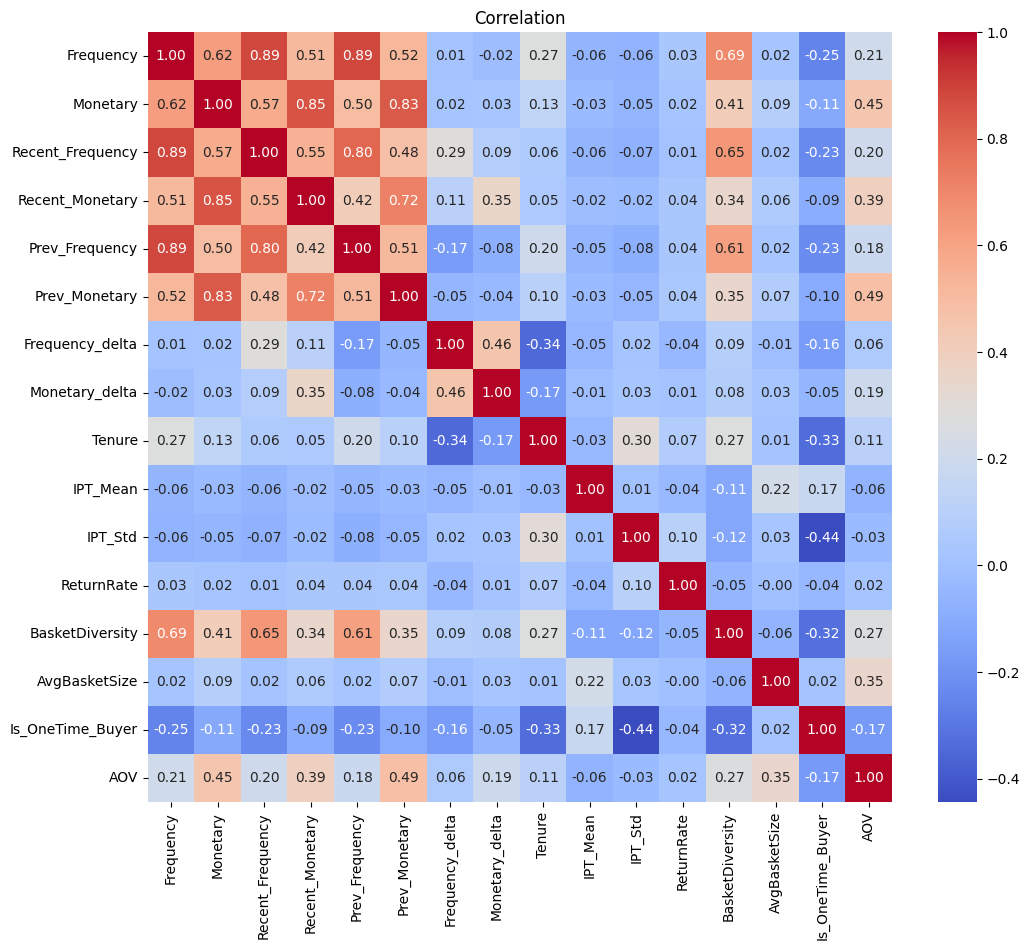

In [5]:
# STEP 2: Feature Engineering 
# A. Tenure (Days since first purchase)
tenure = data.groupby('Customer ID')['InvoiceDate'].min().reset_index()
tenure['Tenure'] = (snapshot_date - tenure['InvoiceDate']).dt.days
tenure = tenure.set_index('Customer ID')['Tenure']

# B. Inter-purchase Time (Buying Rhythm)
# Sort data to calculate the gap between orders
data_sorted = data.sort_values(['Customer ID', 'InvoiceDate'])
data_sorted['Prev_Date'] = data_sorted.groupby('Customer ID')['InvoiceDate'].shift(1)
data_sorted['Days_Diff'] = (data_sorted['InvoiceDate'] - data_sorted['Prev_Date']).dt.days

# Calculate Mean and Std Dev of the gap
ipt = data_sorted.groupby('Customer ID').agg({
    'Days_Diff': ['mean', 'std']
})
ipt.columns = ['IPT_Mean', 'IPT_Std']

max_observed_ipt = ipt['IPT_Mean'].max()
ipt['IPT_Mean'] = ipt['IPT_Mean'].fillna(max_observed_ipt + 30)
ipt['IPT_Std'] = ipt['IPT_Std'].fillna(0) # Odchylenie standardowe 0 jest OK

# C. Behavioral Features
behavior = data.groupby('Customer ID').agg({
    'IsReturn': 'mean',        # Return Rate (% of transactions that are returns)
    'StockCode': 'nunique',    # Basket Diversity (Unique items bought)
    'Quantity': 'mean'         # Average Basket Size
})
behavior.columns = ['ReturnRate', 'BasketDiversity', 'AvgBasketSize']

# 2. MERGE
rfm = rfm.join(tenure).join(ipt).join(behavior).fillna(0)

# 3. DERIVED FEATURES & TARGET

rfm['Is_OneTime_Buyer'] = (rfm['Frequency'] == 1).astype(int)
# AOV (Average Order Value)
rfm['AOV'] = rfm['Monetary'] / (rfm['Frequency'] + 1)

# SMART CHURN DEFINITION
# Logic: Threshold = 3x their average gap (IPT), but at least 90 days.
rfm['Churn_Threshold'] = rfm['IPT_Mean'] * 3
rfm['Churn_Threshold'] = rfm['Churn_Threshold'].clip(lower=90)

# Define Churn:
# 1 = Left, 0 = Stayed
rfm['Churn'] = (rfm['Recency'] > rfm['Churn_Threshold']).astype(int)
# Define X for corr matrix. Remove rest to avoid Data Leakage.
X = rfm.drop(['Churn', 'Recency', 'Churn_Threshold'], axis=1)
# Correlation
plt.figure(figsize=(12, 10))
correlation = X.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation")
plt.show()

In [6]:
# STEP 3: Set Split
# 1. Define y (target)
y = rfm['Churn']

# 2. 80% Train 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- SUMMARY ---")
print(f"All Clients: {len(rfm)}")
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")
print("\nFeatures (X):")
print(list(X.columns))

--- SUMMARY ---
All Clients: 5852
Train: 4681
Test: 1171

Features (X):
['Frequency', 'Monetary', 'Recent_Frequency', 'Recent_Monetary', 'Prev_Frequency', 'Prev_Monetary', 'Frequency_delta', 'Monetary_delta', 'Tenure', 'IPT_Mean', 'IPT_Std', 'ReturnRate', 'BasketDiversity', 'AvgBasketSize', 'Is_OneTime_Buyer', 'AOV']


In [7]:
# STEP 4: Cross-Validation
# 1. Definiujemy procedurę "Pętla w Pętli"
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# 2. Definiujemy siatkę parametrów do sprawdzenia
# Ograniczyłem ją lekko, żebyś nie czekał godziny, ale nadal sprawdzi to co ważne.
param_grid = {
    'n_estimators': [100, 200],         # Liczba drzew
    'max_depth': [4, 6, 8],             # Głębokość (złożoność)
    'min_samples_leaf': [1, 2, 4],      # Minimalna wielkość liścia (ochrona przed przeuczeniem)
    'class_weight': ['balanced', None]  # Czy pomagać mniejszej klasie (Odeszli)?
}

print("🔍 Rozpoczynam Grid Search z podwójną pętlą walidacji...")
print("To może chwilę potrwać (testujemy każdą opcję 15 razy!)... ☕")

# 3. Konfigurujemy Grid Search
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv_method,        # Tu wpinamy naszą "super-walidację"
    scoring='accuracy',        # Optymalizujemy pod F1 (skuteczność wyłapywania odejść)
    n_jobs=1,           # Używamy wszystkich rdzeni procesora
    verbose=1            # Będzie pisać postępy
)

# 4. Odpalamy maszynę
rf_grid.fit(X_train, y_train)

# 5. Wyniki
print("-" * 30)
print(f"🏆 Zwycięskie parametry: {rf_grid.best_params_}")
print(f"💎 Najlepszy średni wynik F1: {rf_grid.best_score_:.2%}")
print("-" * 30)

# 6. Podmieniamy model na ten najlepszy ("Zwycięzcę")
rf_model = rf_grid.best_estimator_
print("✅ Model 'rf_model' został zaktualizowany do najlepszej wersji.")

🔍 Rozpoczynam Grid Search z podwójną pętlą walidacji...
To może chwilę potrwać (testujemy każdą opcję 15 razy!)... ☕
Fitting 15 folds for each of 36 candidates, totalling 540 fits
------------------------------
🏆 Zwycięskie parametry: {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 100}
💎 Najlepszy średni wynik F1: 92.52%
------------------------------
✅ Model 'rf_model' został zaktualizowany do najlepszej wersji.


In [8]:
# STEP 5: Model Setup
print("Generating predictions on the test set...")

# Use the best model (rf_model) to predict Churn on unseen data
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"Model Accuracy: {accuracy:.2%}")
print("-" * 30)
print("Detailed Classification Report:")
# We focus mainly on the F1-Score for Class 1 (Churn) to see how well we catch leaving customers
print(classification_report(y_test, y_pred))

Generating predictions on the test set...
------------------------------
Model Accuracy: 92.91%
------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       583
           1       0.99      0.87      0.92       588

    accuracy                           0.93      1171
   macro avg       0.94      0.93      0.93      1171
weighted avg       0.94      0.93      0.93      1171



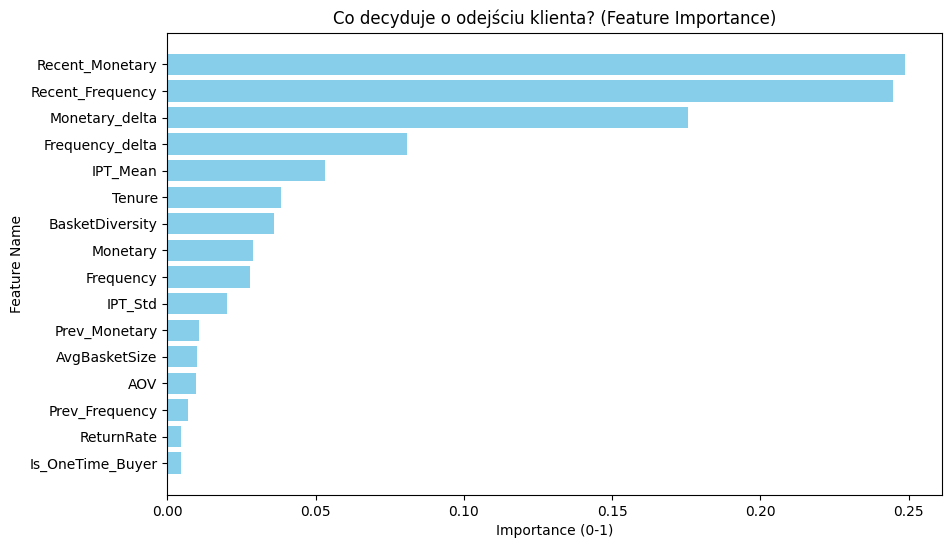

             Feature  Importance
3    Recent_Monetary    0.248906
2   Recent_Frequency    0.244528
7     Monetary_delta    0.175479
6    Frequency_delta    0.080869
9           IPT_Mean    0.053149
8             Tenure    0.038370
12   BasketDiversity    0.035973
1           Monetary    0.028764
0          Frequency    0.027801
10           IPT_Std    0.020200
5      Prev_Monetary    0.010565
13     AvgBasketSize    0.009973
15               AOV    0.009651
4     Prev_Frequency    0.006788
11        ReturnRate    0.004520
14  Is_OneTime_Buyer    0.004465


In [9]:
# STEP 6: Features Importance
# Importances of features
importances = rf_model.feature_importances_
feature_names = X.columns

# Create Table
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance (0-1)')
plt.ylabel('Feature Name')
plt.title('Co decyduje o odejściu klienta? (Feature Importance)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

In [10]:
# STEP 7: Segmentation
# 1. Get probabilities for Class 1 (Churn/Leaving)
# We take the second column [:, 1] which represents the probability of leaving.
churn_probs = rf_model.predict_proba(X_test)[:, 1]

# 2. Create a Results Table
results = pd.DataFrame({
    'Actual_Status': y_test,
    'Churn_Risk': churn_probs
}, index=X_test.index)

# 3. Define Risk Segments
# Logic: "Better Safe Than Sorry" (use >= to include edge cases)
def get_segment(prob):
    if prob >= 0.80: return '🔴 Critical (Lost)'         # High probability of having left
    if prob >= 0.50: return '🟠 At Risk (Save them!)'   # The "Money" group - send coupons here!
    if prob >= 0.20: return '🟡 Watchlist (Monitor)'    # Keep an eye on them
    return '🟢 Safe'                                    # Loyal customers

results['Segment'] = results['Churn_Risk'].apply(get_segment)

# 4. Show Summary
print("\n--- CUSTOMER PORTFOLIO BREAKDOWN ---")
print(results['Segment'].value_counts())

# 5. Show Top Candidates for Campaign (SORTED!)
# We sort by risk descending, so the customers closest to leaving (e.g., 79% risk) appear first.
at_risk_group = results[results['Segment'] == '🟠 At Risk (Save them!)'].sort_values('Churn_Risk', ascending=False)

print(f"\n--- Top 10 Customers to Save (out of {len(at_risk_group)}) ---")
display(at_risk_group.head(10))


--- CUSTOMER PORTFOLIO BREAKDOWN ---
Segment
🔴 Critical (Lost)         494
🟢 Safe                    476
🟡 Watchlist (Monitor)     180
🟠 At Risk (Save them!)     21
Name: count, dtype: int64

--- Top 10 Customers to Save (out of 21) ---


,Actual_Status,Churn_Risk,Segment
Customer ID,,,
16644.0,1,0.796670,🟠 At Risk (Save them!)
12833.0,1,0.796143,🟠 At Risk (Save them!)
17053.0,1,0.788814,🟠 At Risk (Save them!)
16761.0,1,0.787776,🟠 At Risk (Save them!)
12436.0,1,0.782042,🟠 At Risk (Save them!)
14117.0,1,0.763064,🟠 At Risk (Save them!)
16484.0,1,0.763042,🟠 At Risk (Save them!)
16902.0,1,0.749794,🟠 At Risk (Save them!)
13343.0,1,0.749576,🟠 At Risk (Save them!)


In [11]:
# STEP 8: FINANCIAL REPORT (Improved Version)
# 1. Merge results (churn predictions) with monetary value (spending)
# Ensure merging by index (Customer ID)
results_financial = results.join(rfm[['Monetary', 'Recency']], how='left')

# 2. Instead of looking for one specific name, sum the monetary value for EACH segment
risk_report = results_financial.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

print("-" * 40)
print("💰 REVENUE DISTRIBUTION BY SEGMENT")
print("-" * 40)
# Display formatted amounts
for segment, amount in risk_report.items():
    print(f"{segment.ljust(30)} : {amount:,.2f} £")

print("-" * 40)
# Calculate total risk (money in the 'At Risk' segment)
total_risk = risk_report.get('🟠 At Risk (Save them!)', 0)
print(f"⚠️ TOTAL VALUE AT RISK: {total_risk:,.2f} £")

----------------------------------------
💰 REVENUE DISTRIBUTION BY SEGMENT
----------------------------------------
🟢 Safe                         : 2,110,651.24 £
🔴 Critical (Lost)              : 491,738.28 £
🟡 Watchlist (Monitor)          : 323,522.59 £
🟠 At Risk (Save them!)         : 24,561.35 £
----------------------------------------
⚠️ TOTAL VALUE AT RISK: 24,561.35 £
